In [1]:

import os
from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError, MeanAbsolutePercentageError
from sktime.forecasting.compose import ColumnEnsembleForecaster

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

from sktime.split import SlidingWindowSplitter
from sktime.utils.plotting import plot_windows
from sktime.forecasting.base import ForecastingHorizon

from oceanwave_forecast import data_manager, data_pipeline, forecasting_utils

import os
import importlib
import joblib
importlib.reload(data_manager)
importlib.reload(data_pipeline)
importlib.reload(forecasting_utils)

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA, AutoARIMA

from sktime.forecasting.model_evaluation import evaluate


from sktime.split import temporal_train_test_split
from sktime.transformations.compose import ColumnEnsembleTransformer

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs

# PREPARING DATA

In [2]:
# Define the paths to the three .txt files
folder1_txt = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\Standard meteorological data 2024\\46088h2024.txt'
output_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\benchmarks'
processed_data_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\processed'
pipeline_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\pipelines'

data_ocean_raw = data_manager.extract_raw_data(folder1_txt)
data_ocean_raw.info()
processed_data = data_pipeline.preprocess_ocean_data(data_ocean_raw)

# NOTE Truncate the processed data to only include the first 6 months (from Jan 1st to Jun 30th, 2024)
processed_data = processed_data.loc['2024-01-01':'2024-06-30']


processed_data.info()

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


In [3]:
processed_data_Y = processed_data[['WVHT', 'APD']].copy()
processed_data_X = processed_data.drop(columns=['WVHT', 'APD'])

one_day = 24
one_week = one_day * 7
horizon_steps = one_day*3 # 3 days prediction horizon
training_window = one_week*3  # 3 weeks of training data
fh = ForecastingHorizon(list(range(1, horizon_steps + 1)), is_relative=True)

y_train, y_test, X_train, X_test = temporal_train_test_split(y=processed_data_Y, X=processed_data_X, test_size=horizon_steps*3)


In [4]:
pipe_X_path = os.path.join(pipeline_dir, 'pipe_X_fitted.joblib')
pipe_Y_path = os.path.join(pipeline_dir, 'pipe_Y_fitted.joblib')

if os.path.exists(pipe_X_path) and os.path.exists(pipe_Y_path):
    # —————— Load & transform with existing pipelines ——————
    pipe_X = joblib.load(pipe_X_path)
    pipe_Y = joblib.load(pipe_Y_path)

    X_train_transformed = pipe_X.transform(X_train)
    X_test_transformed  = pipe_X.transform(X_test)
    Y_train_transformed = pipe_Y.transform(y_train)
    Y_test_transformed  = pipe_Y.transform(y_test)
    print(f"Loaded pipe_X → {pipe_X_path}")
    print(f"Loaded pipe_Y → {pipe_Y_path}")
else:
    # —————— Create, fit, transform & save new pipelines ——————
    # Assumes data_pipeline.get_pipelines returns (pipe_X, pipe_Y)
    pipe_X, pipe_Y = data_pipeline.get_pipelines(list(X_train.columns))

    X_train_transformed = pipe_X.fit_transform(X_train)
    X_test_transformed  = pipe_X.transform(X_test)
    Y_train_transformed = pipe_Y.fit_transform(y_train)
    Y_test_transformed  = pipe_Y.transform(y_test)

    # ensure the directory exists
    os.makedirs(pipeline_dir, exist_ok=True)
    joblib.dump(pipe_X, pipe_X_path)
    joblib.dump(pipe_Y, pipe_Y_path)

    print(f"Saved pipe_X → {pipe_X_path}")
    print(f"Saved pipe_Y → {pipe_Y_path}")

c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Loaded pipe_X → D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\models\pipelines\pipe_X_fitted.joblib
Loaded pipe_Y → D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\models\pipelines\pipe_Y_fitted.joblib


In [17]:
#### Saving the processed data
# os.makedirs(processed_data_dir, exist_ok=True)

# Export
# X_train_transformed.to_csv(
#     os.path.join(processed_data_dir, 'X_train_transformed.csv'),
#     index=True
# )
# X_test_transformed.to_csv(
#     os.path.join(processed_data_dir, 'X_test_transformed.csv'),
#     index=True
# )
# Y_train_transformed.to_csv(
#     os.path.join(processed_data_dir, 'Y_train_transformed.csv'),
#     index=True
# )
# Y_test_transformed.to_csv(
#     os.path.join(processed_data_dir, 'Y_test_transformed.csv'),
#     index=True
# )

#

Total number of evaluations 11


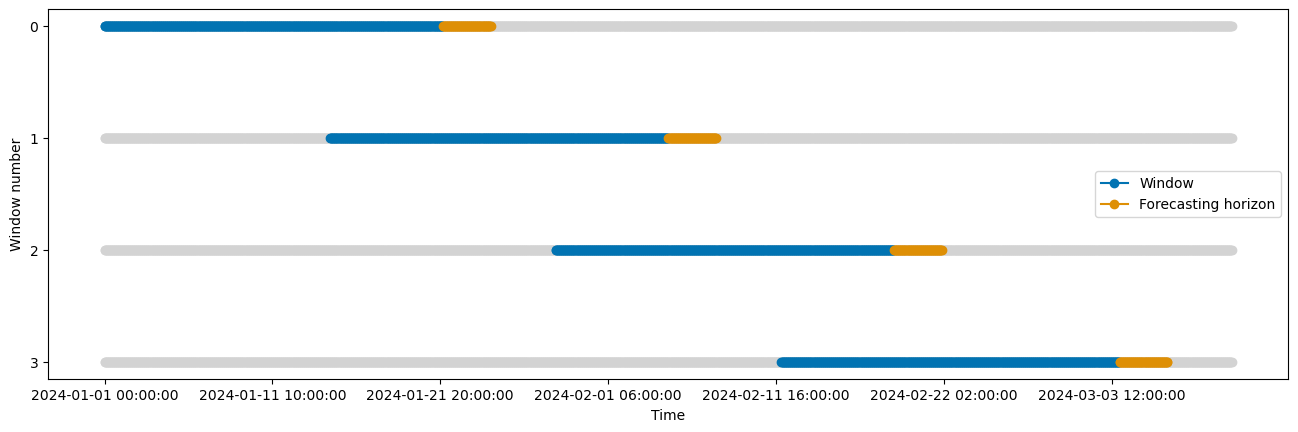

In [5]:


cv = SlidingWindowSplitter(fh=fh, window_length=training_window, step_length = one_week*2)
print("Total number of evaluations",(cv.get_n_splits(Y_train_transformed)))
plot_windows(cv=cv, y=Y_train_transformed[:one_week*10]) # Plotting for the first 6 weeks of data


    # Define metrics
scorers = [
        MeanSquaredPercentageError(),
        MeanAbsolutePercentageError()
    ]


# NAIVE FORECASTER

In [ ]:

    # Define the forecaster 
forecasters = [
    ("naive1", NaiveForecaster(strategy='last'), 0),
    ("naive2", NaiveForecaster(strategy='mean'), 1),
]


results = evaluate(
    forecaster=ColumnEnsembleForecaster(forecasters=forecasters),
    y=Y_train_transformed,
    X=X_train_transformed,
    cv=cv,
    strategy="refit",
    scoring=scorers,
    backend="loky",
    backend_params={"n_jobs": -1},
    return_data=True,
    return_model=True
)



388.4201826434706

In [11]:
# Access the fitted forecaster for the first fold
if 'fitted_forecaster' in results.columns:
    first_fold_forecaster = results['fitted_forecaster'].iloc[0]
    print("\nFitted forecaster type for first fold:", type(first_fold_forecaster).__name__)
    
    # Check if this is a multivariate forecaster (will use ColumnEnsembleForecaster)
    if  type(first_fold_forecaster).__name__ == 'ColumnEnsembleForecaster':
        print("\nThis is a multivariate forecaster with individual models for each target variable:")
        print(first_fold_forecaster)
        
        # For ColumnEnsembleForecaster, the forecasters are stored as a list of tuples
        forecasters = first_fold_forecaster.get_params()['forecasters']
        for name, individual_forecaster, target_idx in forecasters:
            strategy = individual_forecaster.get_params().get('strategy', 'Not specified')
            print(f"  Model for target {target_idx}: {type(individual_forecaster).__name__} "
                  f"with name '{name}' and strategy '{strategy}'")
    else:
        print("\nThis is a single-target forecaster")

# Print summary of results
forecasting_utils.summarize_cv_score(scorers, results)


Fitted forecaster type for first fold: ColumnEnsembleForecaster

This is a multivariate forecaster with individual models for each target variable:
ColumnEnsembleForecaster(forecasters=[('naive1', NaiveForecaster(), 0),
                                      ('naive2',
                                       NaiveForecaster(strategy='mean'), 1)])
  Model for target 0: NaiveForecaster with name 'naive1' and strategy 'last'
  Model for target 1: NaiveForecaster with name 'naive2' and strategy 'mean'
Fold 0:
  MeanSquaredPercentageError for WVHT: 58.9602
  MeanSquaredPercentageError for APD: 7.5240
  MeanAbsolutePercentageError for WVHT: 3.8418
  MeanAbsolutePercentageError for APD: 1.4689
Fold 1:
  MeanSquaredPercentageError for WVHT: 76.2185
  MeanSquaredPercentageError for APD: 41.6875
  MeanAbsolutePercentageError for WVHT: 1.9270
  MeanAbsolutePercentageError for APD: 1.6101
Fold 2:
  MeanSquaredPercentageError for WVHT: 1.1168
  MeanSquaredPercentageError for APD: 2.5758
  MeanAbsolu

In [12]:
best_fold_idx, best_model = forecasting_utils.export_bestmodel_and_results(results, output_dir=output_dir, 
                                                         metric="test_MeanSquaredPercentageError")

Best fold: 2 with test_MeanSquaredPercentageError = 1.8463
Plot for WVHT saved to: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\models\benchmarks\20250508_020344_ColumnEnsembleForecaster_WVHT_plot.png
Plot for APD saved to: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\models\benchmarks\20250508_020344_ColumnEnsembleForecaster_APD_plot.png
Model saved to: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\models\benchmarks\20250508_020344_ColumnEnsembleForecaster_model.pkl
Results saved to: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\models\benchmarks\20250508_020344_ColumnEnsembleForecaster_cv_results.csv


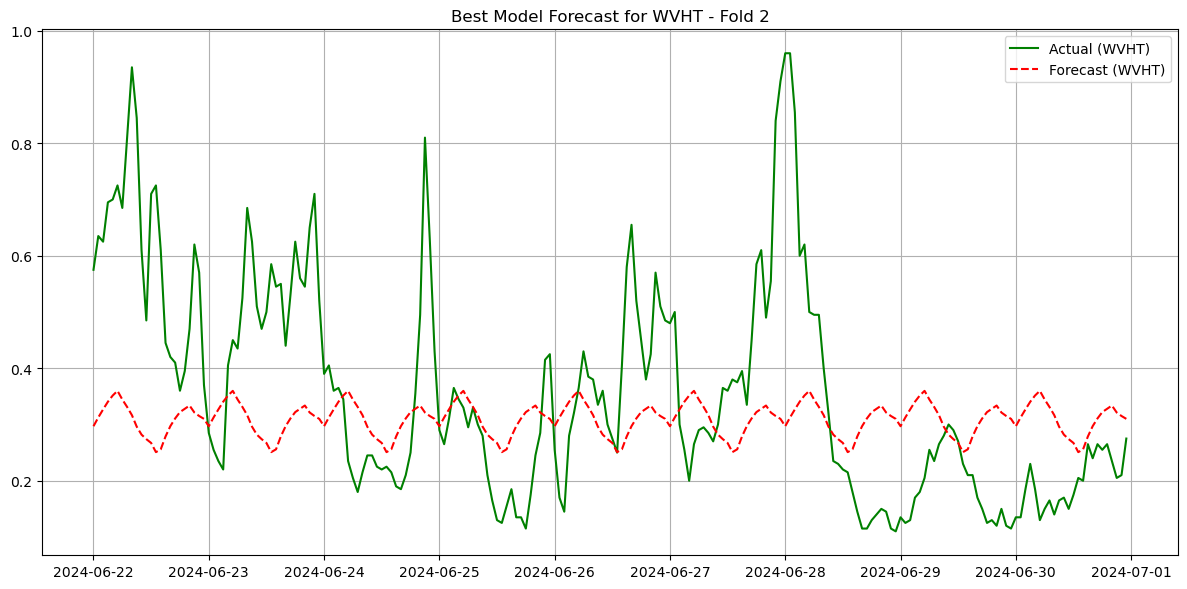

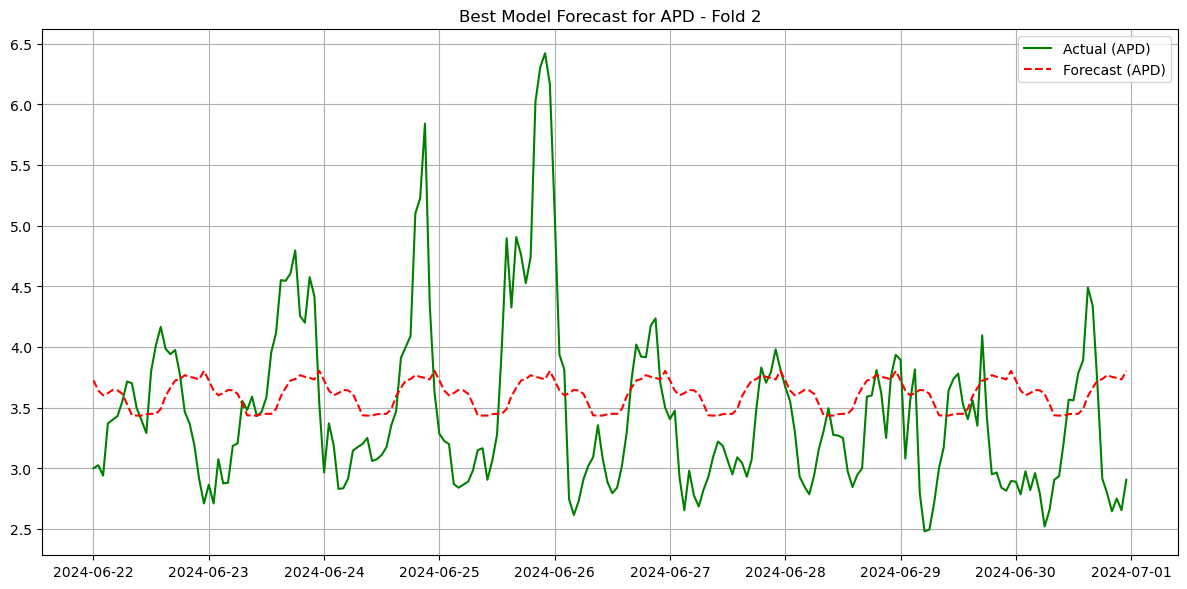

MeanSquaredPercentageError → 0.2373
MeanAbsolutePercentageError → 0.3300


In [13]:
# Test Dataset plot comparison
y_pred = best_model.predict(ForecastingHorizon(y_test.index, is_relative=False))
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            
            
            # Plot test and predictions
            plt.plot(y_test[target], label=f'Actual ({target})', color='green')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='red', linestyle='--')
            
            plt.title(f'Best Model Forecast for {target} - Fold {best_fold_idx}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


for scorer in scorers:
    name   = scorer.__class__.__name__
    value  = scorer(y_test, y_pred)
    print(f"{name} → {value:.4f}")

# AUTOARIMA

In [23]:
common_kwargs = dict(
    sp=24,                # seasonal period = 24 hours
    start_p=1,            # starting AR order
    start_q=1,            # starting MA order
    max_p=3,              # max AR order
    max_q=2,              # max MA order
    max_d = 1,           # max differencing order
    max_D = 1,           # max seasonal differencing order
    max_P=1,          # max seasonal AR order
    max_Q=1,          # max seasonal MA order
    seasonal=True,        # seasonal ARIMA
    information_criterion="aic",
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    n_jobs=-1,
)

    # Define the forecaster 
forecasters = [
    ("ARIMA1", AutoARIMA(**common_kwargs), 0),
    ("ARIMA2", AutoARIMA(**common_kwargs), 1),
]

results = evaluate(
    forecaster=ColumnEnsembleForecaster(forecasters=forecasters),
    y=Y_train_transformed,
    X=X_train_transformed,
    cv=cv,
    strategy="update", # Make sure p,q,d etc remain the same for all folds
    scoring=scorers,
    backend="loky",
    backend_params = {
        "n_jobs":  -1,   # your usual setting
        "verbose": 1,   # <-- add this line
    },
    return_data=True,
    return_model=True
)



KeyboardInterrupt: 

# SARIMA

,WVHT,APD
datetime,,
2024-01-01 00:00:00,-0.781476,0.785778
2024-01-01 01:00:00,-0.768626,1.566419
2024-01-01 02:00:00,-0.883475,1.638497
2024-01-01 03:00:00,-0.967204,2.339293
2024-01-01 04:00:00,-1.014186,2.729373
...,...,...
2024-06-21 19:00:00,-0.214233,1.523277
2024-06-21 20:00:00,0.251361,1.146381
2024-06-21 21:00:00,0.287603,-0.470981


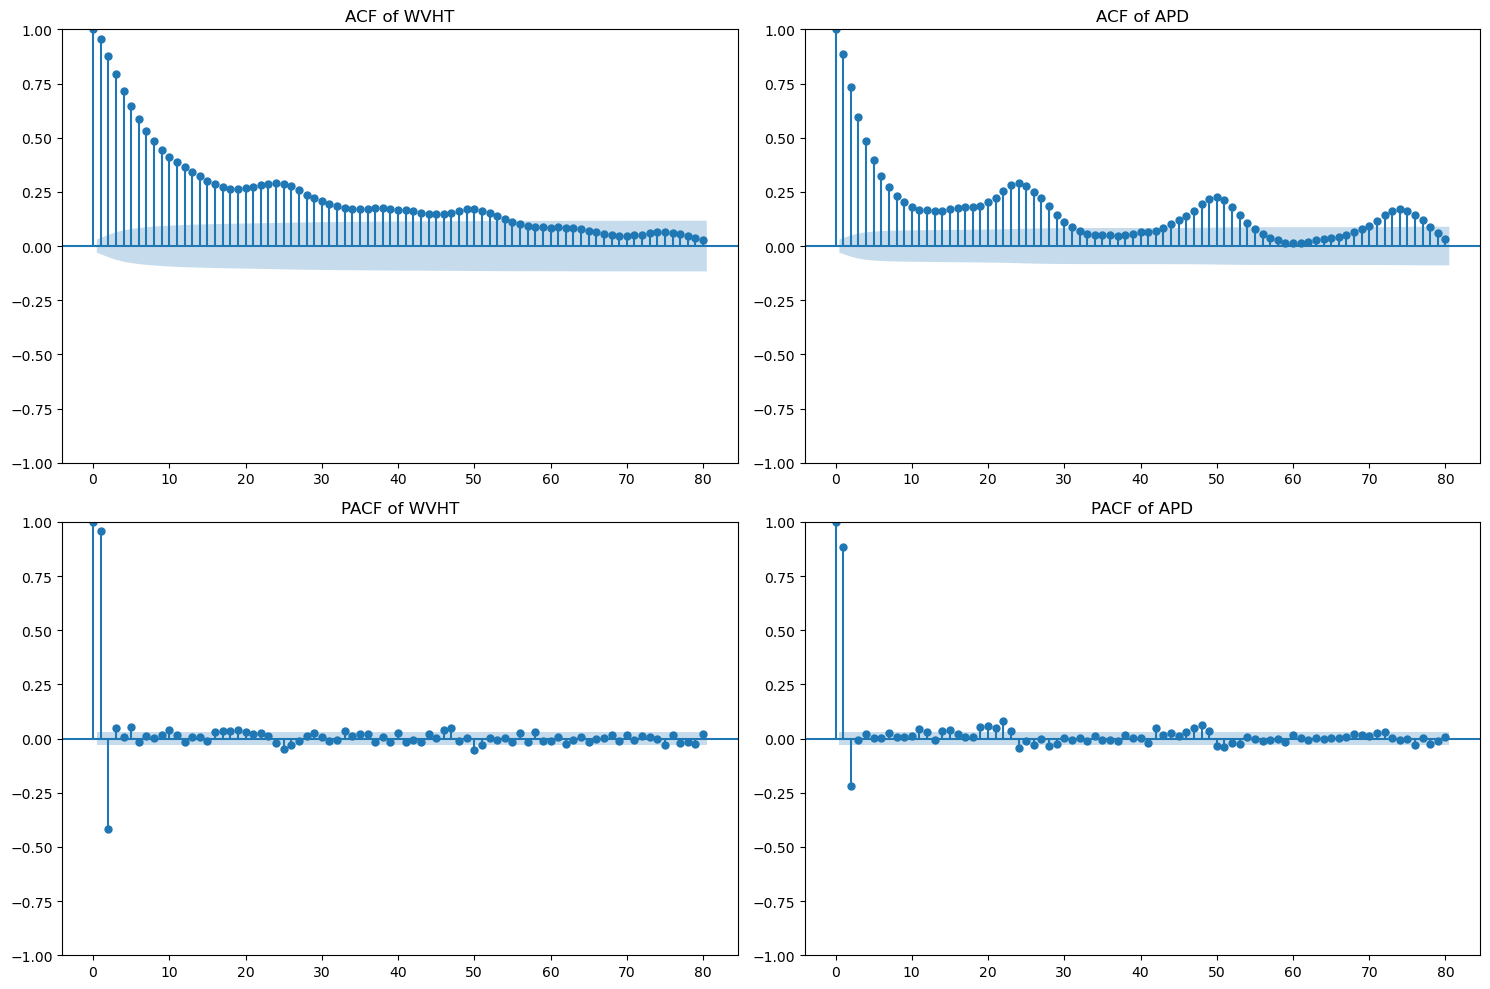

In [17]:

# Plotting ACF and PACF for the transformed training data

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First row: ACF plots
for i, col in enumerate(Y_train_transformed.columns):
    plot_acf(Y_train_transformed[col], lags=80, ax=axes[0, i])
    axes[0, i].set_title(f"ACF of {col}")

# Second row: PACF plots (imported here if not already available)
for i, col in enumerate(Y_train_transformed.columns):
    plot_pacf(Y_train_transformed[col], lags=80, ax=axes[1, i])
    axes[1, i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()

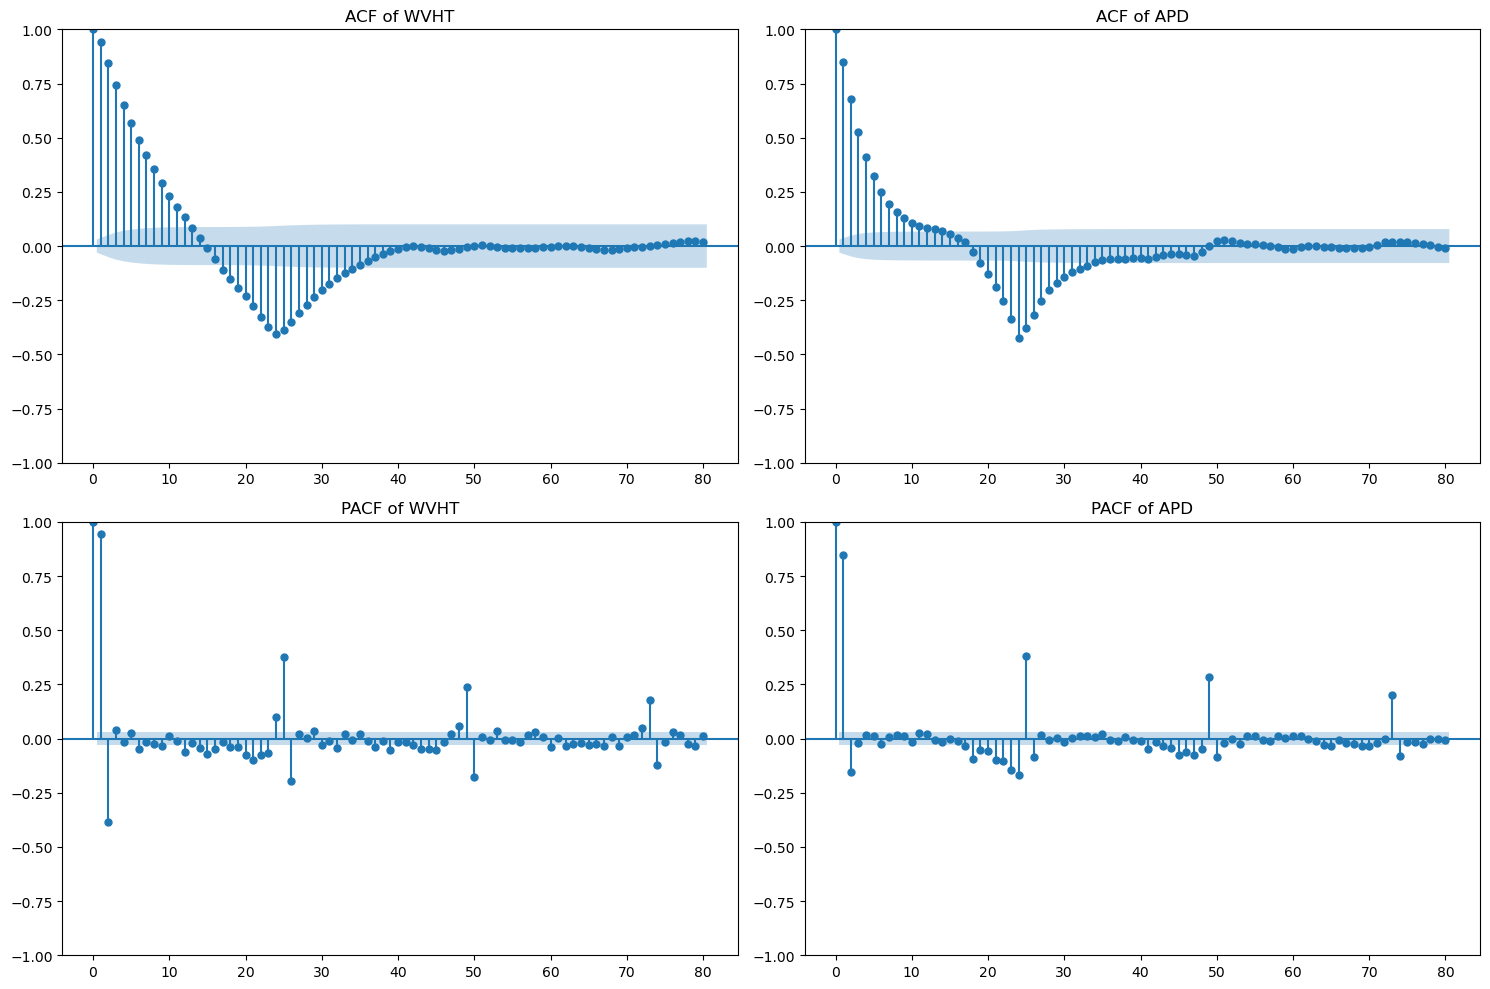

In [ ]:
# Notes:
# We see a downward trend in ACF: A non-seasonal AR(1)
# We need peaks of 12, 24, 36, 48, 60, 72, 84: A seasonal MA(1) 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First row: ACF plots
for i, col in enumerate(Y_train_transformed.columns):
    series =Y_train_transformed[col]
    series = series.diff(24).dropna()
    plot_acf(series, lags=80, ax=axes[0, i])
    axes[0, i].set_title(f"ACF of {col}")

# Second row: PACF plots (imported here if not already available)
for i, col in enumerate(Y_train_transformed.columns):
    series =Y_train_transformed[col]
    series = series.diff(24).dropna()
    plot_pacf(series, lags=80, ax=axes[1, i])
    axes[1, i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()

In [29]:
from sktime.forecasting.sarimax import SARIMAX

forecasters = [
    ("SARIMA1",SARIMAX( order=(1, 0, 0), seasonal_order=(0, 1, 1, 24))  , 0),
    ("SARIMA2", SARIMAX( order=(1, 0, 0), seasonal_order=(0, 1, 1, 24))  , 1),
]

results = evaluate(
    forecaster=ColumnEnsembleForecaster(forecasters=forecasters),
    y=Y_train_transformed,
    X=X_train_transformed,
    cv=cv,
    strategy="refit", # Make sure p,q,d etc remain the same for all folds
    scoring=scorers,
    backend="loky",
    backend_params = {
        "n_jobs":  -1,   # your usual setting
        "verbose": 1,   # <-- add this line
    },
    return_data=True,
    return_model=True
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

In [26]:

if 'fitted_forecaster' in results.columns:
    first_fold_forecaster = results['fitted_forecaster'].iloc[0]
    print("\nFitted forecaster type for first fold:", type(first_fold_forecaster).__name__)
    
    # Check if this is a multivariate forecaster (will use ColumnEnsembleForecaster)
    if  type(first_fold_forecaster).__name__ == 'ColumnEnsembleForecaster':
        print("\nThis is a multivariate forecaster with individual models for each target variable:")
        print(first_fold_forecaster)
        
        # For ColumnEnsembleForecaster, the forecasters are stored as a list of tuples
        forecasters = first_fold_forecaster.get_params()['forecasters']
        for name, individual_forecaster, target_idx in forecasters:
            strategy = individual_forecaster.get_params().get('strategy', 'Not specified')
            print(f"  Model for target {target_idx}: {type(individual_forecaster).__name__} "
                  f"with name '{name}' and strategy '{strategy}'")
    else:
        print("\nThis is a single-target forecaster")

# Print summary of results
forecasting_utils.summarize_cv_score(scorers, results)

best_fold_idx, best_model = forecasting_utils.export_bestmodel_and_results(results, output_dir=output_dir, 
                                                         metric="test_MeanSquaredPercentageError")


Fitted forecaster type for first fold: ColumnEnsembleForecaster

This is a multivariate forecaster with individual models for each target variable:
ColumnEnsembleForecaster(forecasters=[('SARIMA1',
                                       SARIMAX(seasonal_order=(0, 1, 1, 24)),
                                       0),
                                      ('SARIMA2',
                                       SARIMAX(seasonal_order=(0, 1, 1, 24)), 0,
                                       1)])


ValueError: too many values to unpack (expected 3)

Models Cutoff Date: 2024-12-01 23:00:00
X_test Start Date: 2024-12-23 00:00:00


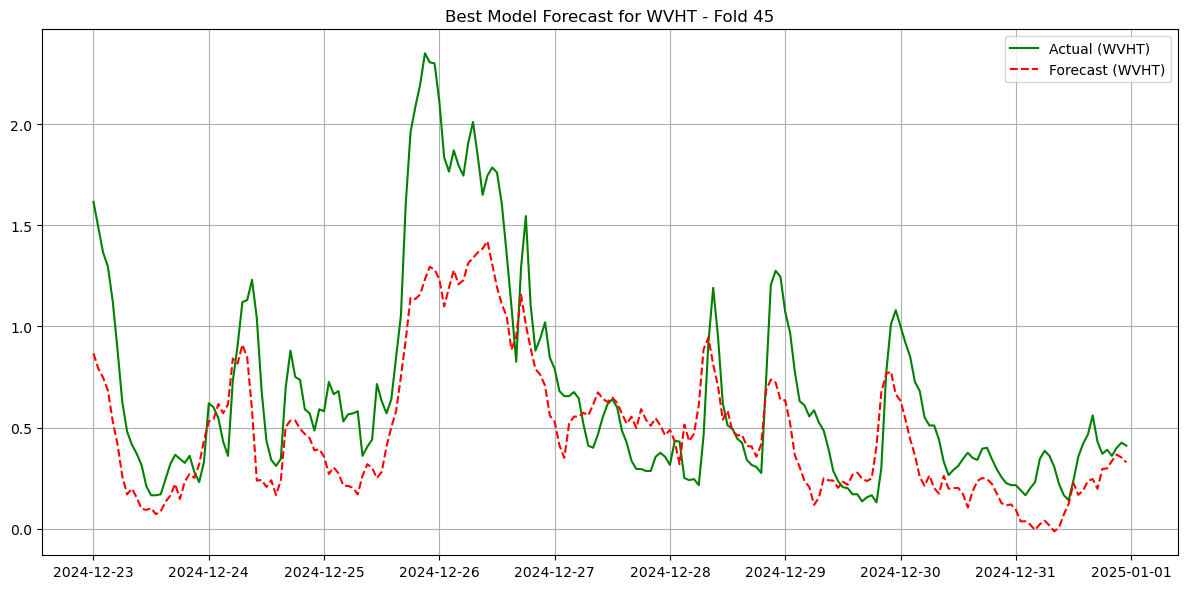

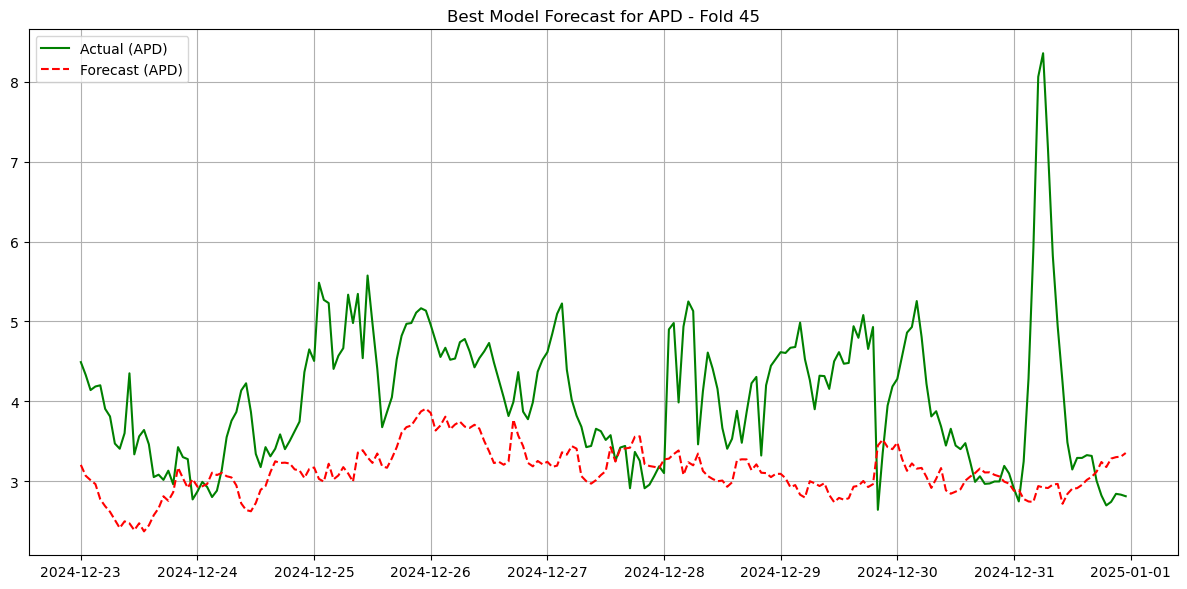

MeanSquaredPercentageError → 0.1647
MeanAbsolutePercentageError → 0.3252


In [ ]:
# Comparing the prediction of the best model
y_pred = forecasting_utils.forecast_with_exog(best_model, X_train_transformed, X_test_transformed)
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            
            
            # Plot test and predictions
            plt.plot(y_test[target], label=f'Actual ({target})', color='green')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='red', linestyle='--')
            
            plt.title(f'Best Model Forecast for {target} - Fold {best_fold_idx}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


for scorer in scorers:
    name   = scorer.__class__.__name__
    value  = scorer(y_test, y_pred)
    print(f"{name} → {value:.4f}")

In [ ]:
# last_model = results['fitted_forecaster'].iloc[-1]

# y_pred = forecasting_utils.forecast_with_exog(last_model, X_train_transformed, X_test_transformed)
# y_pred = pipe_Y.inverse_transform(y_pred)

# for target in y_pred.columns:  # Assumes y_pred columns are the target columns
#             plt.figure(figsize=(12, 6))
            
            
#             # Plot test and predictions
#             plt.plot(y_test[target], label=f'Actual ({target})', color='green')
#             plt.plot(y_pred[target], label=f'Forecast ({target})', color='red', linestyle='--')
            
#             plt.title(f'Last Model from the folds Forecast for {target}')
#             plt.legend()
#             plt.grid(True)
#             plt.tight_layout()
#             plt.show()


# for scorer in scorers:
#     name   = scorer.__class__.__name__
#     value  = scorer(y_test, y_pred)
#     print(f"{name} → {value:.4f}")